In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('./data/TableS7-cell_metadata.csv',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('./data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


# correlation between mC and RNA

In [3]:
rna_data=pd.read_csv('/cndd2/jchien/project/CZI_human/pseudobulk_rna/logcpm/donor/allcelltypes_donoraveage_log2cpm+1.tsv.gz',sep='\t',index_col=0)[level2_order]
mch_data=pd.read_csv('/cndd2/jchien/project/CZI_human/pseudobulk_allc/region/intragenic_mCH_all.tsv.gz',sep='\t',index_col=0,header=[0,1]).T.reset_index().groupby(['level_0']).mean().T[level2_order]

In [4]:
df=pd.DataFrame(index=list((set(rna_data.index).intersection(set(mch_data.index)))),columns=['r','p'])
for i in df.index:
    df.loc[i]=sc.stats.spearmanr(rna_data.loc[i],mch_data.loc[i])
df=df.join(rna_data.mean(axis=1).to_frame('meanRNA'))
df=df.join(mch_data.mean(axis=1).to_frame('meanmch'))
df=df.join(gene_meta)
df['len']=df['end']-df['start']

Text(0.5, 0, 'spearmanr bwteen RNA and genebody mCH')

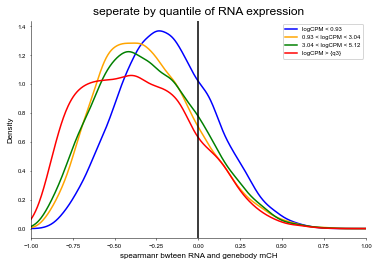

In [5]:
q1,q2,q3=df['meanRNA'].quantile([0.5,0.75,0.9])
df[df['meanRNA']<q1]['r'].plot(kind = "kde",c='b',label=f'logCPM < {q1:.2f}')
df[(df['meanRNA']>q1)&(df['meanRNA']<q2)]['r'].plot(kind = "kde",c='orange',label=f'{q1:.2f} < logCPM < {q2:.2f}')
df[(df['meanRNA']>q2)&(df['meanRNA']<q3)]['r'].plot(kind = "kde",c='g',label=f'{q2:.2f} < logCPM < {q3:.2f}')
df[df['meanRNA']>q3]['r'].plot(kind = "kde",c='r',label='logCPM > {q3}')
plt.axvline(x=0,c='k')
plt.legend()
plt.xlim([-1,1])
plt.title('seperate by quantile of RNA expression')
plt.xlabel('spearmanr bwteen RNA and genebody mCH')

Text(0.5, 0, 'spearmanr bwteen RNA and genebody mCH')

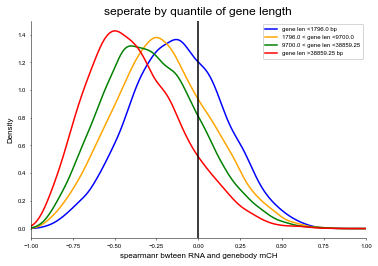

In [6]:
q1,q2,q3=df['len'].quantile([0.25,0.5,0.75])
df[df['len']<q1]['r'].plot(kind = "kde",c='b',label=f'gene len <{q1} bp')
df[(df['len']>q1)&(df['len']<q2)]['r'].plot(kind = "kde",c='orange',label=f'{q1} < gene len <{q2}')
df[(df['len']>q2)&(df['len']<q3)]['r'].plot(kind = "kde",c='g',label=f'{q2} < gene len <{q3}')
df[df['len']>q3]['r'].plot(kind = "kde",c='r',label=f'gene len >{q3} bp')
plt.axvline(x=0,c='k')
plt.legend()
plt.xlim([-1,1])
plt.title('seperate by quantile of gene length')
plt.xlabel('spearmanr bwteen RNA and genebody mCH')

# individual variantion

RNA between donor: 0.903 +- 0.030
RNA within donor: 0.982 +- 0.005
mCG between donor: 0.968 +- 0.010
mCG within donor: 0.993 +- 0.005
mCH between donor: 0.909 +- 0.031
mCH within donor: 0.982 +- 0.008


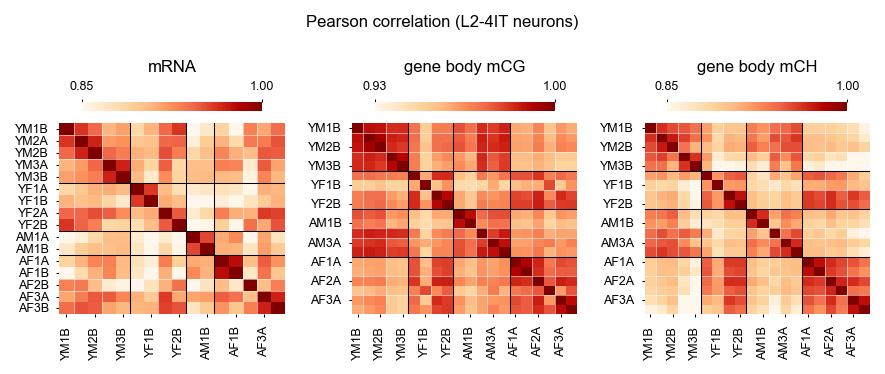

In [7]:
fig,axs=plt.subplots(1,3,figsize=(6,2.5),dpi=dpi)
ax=axs[0]
df=pd.read_csv('/cndd2/jchien/project/CZI_human/pseudobulk_rna/logcpm/L2-4IT_CUX2_log2cpm+1.tsv.gz',sep='\t',index_col=0).replace(0,np.nan).dropna()
df=df[cziplot.sample_order_rna]

###### filter high variable genes ###################
df=df.loc[set(df.index).intersection(set(gene_meta[(gene_meta['fn'].isin(['protein_coding','lncRNA']))].index))]
df=df.loc[df.std(axis=1).sort_values().tail(10000).index]

corr=df.corr('pearson')

sns.heatmap(corr.loc[cziplot.sample_order_rna,cziplot.sample_order_rna],cmap='OrRd',vmin=0.85,ax=ax,
            cbar_kws={'orientation': 'horizontal','location':"top",
                'label':'mRNA','ticks':[.85,1],'shrink':.8})
for xc in [1,3,5,7,9,11,13,14]:
    ax.axvline(x=xc,c='white',linewidth=0.25)
for yc in [1,3,5,7,9,11,13,14]:
    ax.axhline(y=yc,c='white',linewidth=0.25)
for xc in [5,9,11]:
    ax.axvline(x=xc,c='k',linewidth=0.5)
for yc in [5,9,11]:
    ax.axhline(y=yc,c='k',linewidth=0.5)
corr['donor']=corr.index.str[0:3]
corr=corr.groupby('donor').mean().T
corr['donor']=corr.index.str[0:3]
corr=corr.groupby('donor').mean()
print(f'RNA between donor: {np.nanmean(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f} +- {np.nanstd(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f}')
corr=np.diag(corr[~corr.index.isin(['AF2','YM1'])][corr.columns[~corr.columns.isin(['AF2','YM1'])]])
print(f'RNA within donor: {corr.mean():.3f} +- {corr.std():.3f}')

ax=axs[1]
df=pd.read_csv('/cndd2/jchien/project/CZI_human/pseudobulk_allc/sample/region_sample/intragenic/intragenic_mCG_L2-4IT_CUX2_cov100.tsv.gz',sep='\t',index_col=0).replace(0,np.nan).dropna()
df=df.loc[set(df.index).intersection(set(gene_meta[(gene_meta['fn'].isin(['protein_coding','lncRNA']))].index))]
df=df.loc[df.std(axis=1).sort_values().tail(10000).index]
corr=df.corr('pearson')
g=sns.heatmap(corr.loc[cziplot.sample_order,cziplot.sample_order],cmap='OrRd',vmin=0.93,ax=ax,
            cbar_kws={'orientation': 'horizontal','location':"top",
                'label':'gene body mCG','ticks':[.93,1],'shrink':.8})
for xc in [1,3,5,7,9,11,12,14,16,18]:
    ax.axvline(x=xc,c='white',linewidth=0.25)
for yc in [1,3,5,7,9,11,12,14,16,18]:
    ax.axhline(y=yc,c='white',linewidth=0.25)
for xc in [5,9,14]:
    ax.axvline(x=xc,c='k',linewidth=0.5)
for yc in [5,9,14]:
    ax.axhline(y=yc,c='k',linewidth=0.5)
corr['donor']=corr.index.str[0:3]
corr=corr.groupby('donor').mean().T
corr['donor']=corr.index.str[0:3]
corr=corr.groupby('donor').mean()
print(f'mCG between donor: {np.nanmean(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f} +- {np.nanstd(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f}')
corr=np.diag(corr[~corr.index.isin(['AM2','YM1'])][corr.columns[~corr.columns.isin(['AM2','YM1'])]])
print(f'mCG within donor: {corr.mean():.3f} +- {corr.std():.3f}')
    
ax=axs[2]
df=pd.read_csv('/cndd2/jchien/project/CZI_human/pseudobulk_allc/sample/region_sample/intragenic/intragenic_mCH_L2-4IT_CUX2_cov100.tsv.gz',sep='\t',index_col=0).replace(0,np.nan).dropna()
df=df.loc[set(df.index).intersection(set(gene_meta[(gene_meta['fn'].isin(['protein_coding','lncRNA']))].index))]
df=df.loc[df.std(axis=1).sort_values().tail(10000).index]
corr=df.corr('pearson')
g=sns.heatmap(corr.loc[cziplot.sample_order,cziplot.sample_order],cmap='OrRd',vmin=0.85,ax=ax,
            cbar_kws={'orientation': 'horizontal','location':"top",
                'label':'gene body mCH','ticks':[.85,1],'shrink':.8})
for xc in [1,3,5,7,9,11,12,14,16,18]:
    ax.axvline(x=xc,c='white',linewidth=0.25)
for yc in [1,3,5,7,9,11,12,14,16,18]:
    ax.axhline(y=yc,c='white',linewidth=0.25)
for xc in [5,9,14]:
    ax.axvline(x=xc,c='k',linewidth=0.5)
for yc in [5,9,14]:
    ax.axhline(y=yc,c='k',linewidth=0.5)
corr['donor']=corr.index.str[0:3]
corr=corr.groupby('donor').mean().T
corr['donor']=corr.index.str[0:3]
corr=corr.groupby('donor').mean()
print(f'mCH between donor: {np.nanmean(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f} +- {np.nanstd(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f}')
corr=np.diag(corr[~corr.index.isin(['AM2','YM1'])][corr.columns[~corr.columns.isin(['AM2','YM1'])]])
print(f'mCH within donor: {corr.mean():.3f} +- {corr.std():.3f}')

plt.suptitle('Pearson correlation (L2-4IT neurons)')
plt.tight_layout()

# cell type variation

RNA between celltype: 0.728 +- 0.077
mCG between celltype: 0.798 +- 0.069
mCH between celltype: 0.484 +- 0.150


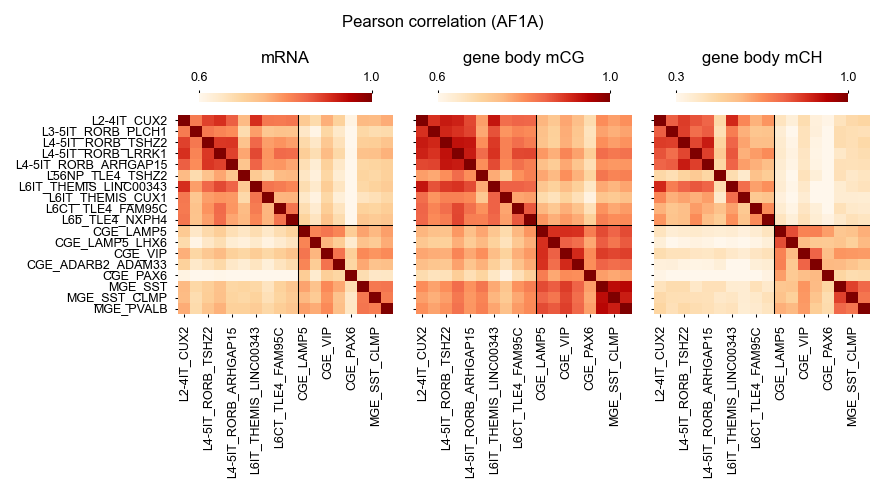

In [8]:
fig,axs=plt.subplots(1,3,figsize=(6,3.3),dpi=dpi,sharey=True)
ax=axs[0]
df=[]
for celltype in level2_order:
    file=f'/cndd2/jchien/project/CZI_human/pseudobulk_rna/logcpm/{celltype}_log2cpm+1.tsv.gz'
    tmp=pd.read_csv(file,sep='\t',index_col=0)
    tmp=tmp[['AF1A']]
    tmp.columns=[celltype]
    df.append(tmp[celltype])
df=pd.DataFrame(df).T
df=df.loc[set(df.index).intersection(set(gene_meta[(gene_meta['fn'].isin(['protein_coding','lncRNA']))].index))]
df=df.loc[df.std(axis=1).sort_values().tail(10000).index]
corr=df.corr('pearson')
sns.heatmap(corr.loc[cziplot.level2_order,cziplot.level2_order],cmap='OrRd',vmin=0.6,ax=ax,
            cbar_kws={'orientation': 'horizontal','location':"top",
                'label':'mRNA','ticks':[0.6,1],'shrink':.8})
for xc in [10]:
    ax.axvline(x=xc,c='k',linewidth=0.5)
    ax.axhline(y=xc,c='k',linewidth=0.5)
print(f'RNA between celltype: {np.nanmean(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f} +- {np.nanstd(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f}')

ax=axs[1]
df=[]
for celltype in level2_order:
    file=f'/cndd2/jchien/project/CZI_human/pseudobulk_allc/sample/region_sample/intragenic/{celltype}-AF1A.intragenic_CGN-Both.sparse.bed.gz'
    tmp=pd.read_csv(file,sep='\t',usecols=[3,8,9],index_col=0,names=['gene_id','mc','c'])
    tmp[celltype]=tmp['mc']/tmp['c']
    df.append(tmp[celltype])
df=pd.DataFrame(df).T
df=df.loc[set(df.index).intersection(set(gene_meta[(gene_meta['fn'].isin(['protein_coding','lncRNA']))].index))]
df=df.loc[df.std(axis=1).sort_values().tail(10000).index]
corr=df.corr('pearson')
g=sns.heatmap(corr.loc[cziplot.level2_order,cziplot.level2_order],cmap='OrRd',vmin=0.6,ax=ax,
            cbar_kws={'orientation': 'horizontal','location':"top",
                'label':'gene body mCG','ticks':[0.6,1],'shrink':.8})
for xc in [10]:
    ax.axvline(x=xc,c='k',linewidth=0.5)
    ax.axhline(y=xc,c='k',linewidth=0.5)
print(f'mCG between celltype: {np.nanmean(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f} +- {np.nanstd(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f}')
    
ax=axs[2]
df=[]
for celltype in level2_order:
    file=f'/cndd2/jchien/project/CZI_human/pseudobulk_allc/sample/region_sample/intragenic/{celltype}-AF1A.intragenic_CHN-Both.sparse.bed.gz'
    tmp=pd.read_csv(file,sep='\t',usecols=[3,8,9],index_col=0,names=['gene_id','mc','c'])
    tmp[celltype]=tmp['mc']/tmp['c']
    df.append(tmp[celltype])
df=pd.DataFrame(df).T
df=df.loc[set(df.index).intersection(set(gene_meta[(gene_meta['fn'].isin(['protein_coding','lncRNA']))].index))]
df=df.loc[df.std(axis=1).sort_values().tail(10000).index]
corr=df.corr('pearson')
g=sns.heatmap(corr.loc[cziplot.level2_order,cziplot.level2_order],cmap='OrRd',vmin=0.3,ax=ax,
            cbar_kws={'orientation': 'horizontal','location':"top",
                'label':'gene body mCH','ticks':[.3,1],'shrink':.8})
for xc in [10]:
    ax.axvline(x=xc,c='k',linewidth=0.5)
    ax.axhline(y=xc,c='k',linewidth=0.5)
print(f'mCH between celltype: {np.nanmean(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f} +- {np.nanstd(corr.mask(np.eye(len(corr), dtype = bool)).values):.3f}')

plt.suptitle('Pearson correlation (AF1A)')
plt.tight_layout()